In [31]:
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.filters import gaussian, sobel, sobel_h, sobel_v
# from skimage.morphology import skeletonize
from skimage.transform import hough_line, hough_line_peaks
import numpy as np
import math

In [ ]:
CALIBRATION_LEFT_FILEPATH = '../../data/2025-06-26/nerds/calibration_left.tif'
CALIBRATION_RIGHT_FILEPATH = '../../data/2025-06-26/nerds/calibration_right.tif'

# CALIBRATION_TEST_LEFT_FILEPATH = '../../data/2025-06-13/calibration_left.tif'
# CALIBRATION_TEST_RIGHT_FILEPATH = '../../data/2025-06-13/calibration_right.tif'
# TEST_IMAGE = '../../data/toys/line_outline.png'

GRID_DIMENSIONS = (4,4)

BINARY_THRESHOLD = 3/10

ORTHOG_ERROR = 2*(np.pi) / 90 # ALLOWED ORTHOGONAL ERROR

NUM_LINES = GRID_DIMENSIONS[0] + GRID_DIMENSIONS[1] + 2
im = plt.imread(CALIBRATION_LEFT_FILEPATH)[:,:,0]
# im = plt.imread(CALIBRATION_RIGHT_FILEPATH)[:,:,0]
# im = plt.imread(CALIBRATION_TEST_LEFT_FILEPATH)[:,:,0]
# im = plt.imread(CALIBRATION_TEST_RIGHT_FILEPATH)[:,:,0]


# im = plt.imread(TEST_IMAGE)[:,:,0]


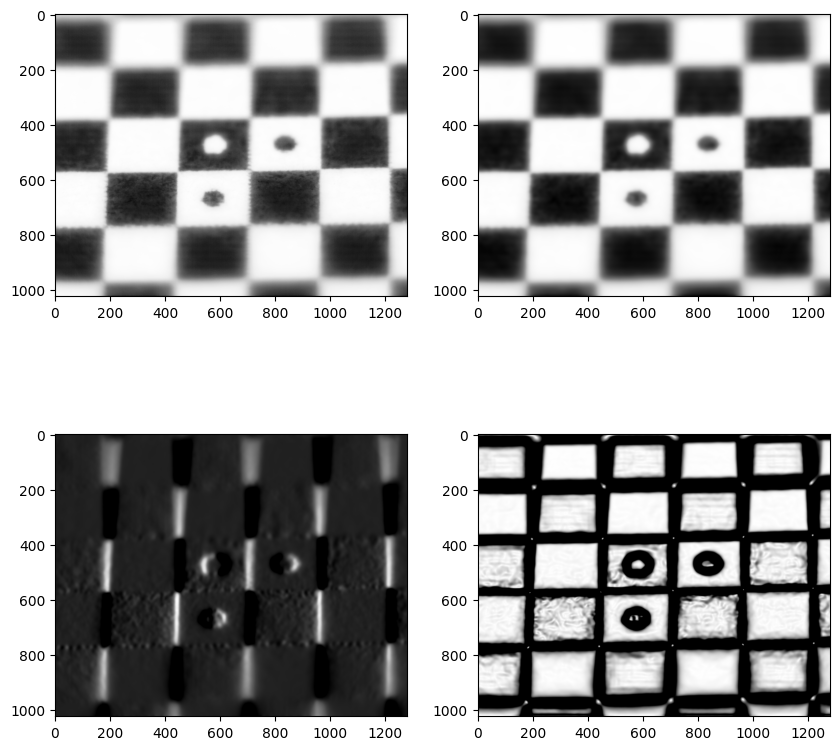

In [35]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(im,cmap='Greys')
plt.subplot(2,2,2)
im_blur = gaussian(im,sigma=5)
plt.imshow(im_blur,cmap='Greys')
plt.subplot(2,2,3)
plt.imshow(sobel_v(im_blur)*100,vmax=1,cmap='Greys')
plt.subplot(2,2,4)
plt.imshow(sobel(im_blur)*100,vmax=1,cmap='Greys')

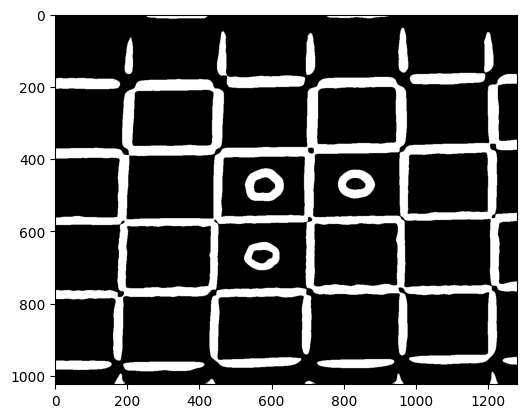

In [36]:
# from skimage.morphology import skeletonize

im_sobel = sobel(im_blur)
# im_sobel = 255 - im_sobel

threshold = im_sobel.max() * BINARY_THRESHOLD


thresholded = im_sobel > threshold

# SOBEL SPACE MAX VALUE DIVIDED BY CONSTANT S.T. EACH IMAGE THRESHOLD DEPENDENT ON CONDITIONS

# thresholded = np.invert(thresholded)
# skeleton = skeletonize(thresholded)
plt.imshow(thresholded,cmap=cm.grey)

# plt.imshow(im_sobel,cmap=cm.grey)

4.974125234073121 569.9782961465777
6.876248136289738 393.93999189161815
13.490710176020222 772.8822683558905
3.525386100331287 201.96923442159104
17.016096276351508 974.8515027774815
1201.954231523134 -10.489295669045498
961.9633699877328 8.394927149435725
463.84099878865857 12.146104014853142
212.8702461550674 7.4335927976327065
702.9732319141124 6.134754455356876


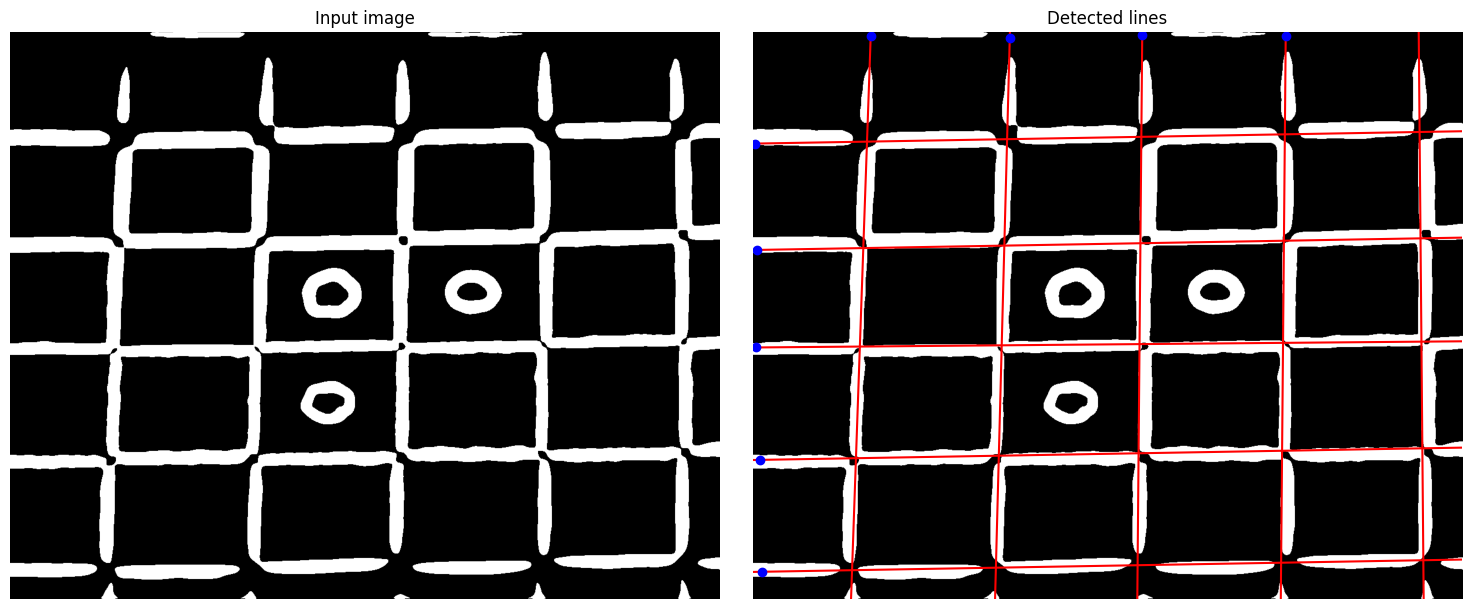

In [37]:
tested_angles = np.linspace(-(np.pi / 2)+(np.pi/2), (np.pi / 2)+(np.pi/2), 360, endpoint=False)

h, theta, d = hough_line(thresholded, theta=tested_angles)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(thresholded, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(thresholded, cmap=cm.gray)
ax[1].set_ylim((thresholded.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

line_r0s = []
line_angles = []

for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=NUM_LINES, min_distance=100)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    line_r0s.append((x0,y0))
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi / 2),c='red')
    ax[1].plot(x0,y0,'bo')
    line_angles.append(np.tan(angle + np.pi / 2))
    print(x0,y0)

plt.tight_layout()
plt.show()


In [65]:
def line_intersection(x1, y1, angle1, x2, y2, angle2):
    # Direction vectors
    dx1, dy1 = np.cos(angle1 + np.pi/2), np.sin(angle1 + np.pi/2)
    dx2, dy2 = np.cos(angle2 + np.pi/2), np.sin(angle2 + np.pi/2)
    
    # Check if lines are parallel
    det = dx1 * dy2 - dx2 * dy1
    if abs(det) < 1e-10:
        return None
    
    # Solve for intersection
    # Line 1: (x1, y1) + t1 * (dx1, dy1)
    # Line 2: (x2, y2) + t2 * (dx2, dy2)
    # Set equal and solve for t1
    
    t1 = ((x2 - x1) * dy2 - (y2 - y1) * dx2) / det
    
    x_intersect = x1 + t1 * dx1
    y_intersect = y1 + t1 * dy1
    
    return (x_intersect, y_intersect)

def find_all_intersections(points_angles):
    intersections = []
    n = len(points_angles)
    
    for i in range(n):
        for j in range(i + 1, n):
            x1, y1, angle1 = points_angles[i]
            x2, y2, angle2 = points_angles[j]
            
            intersection = line_intersection(x1, y1, angle1, x2, y2, angle2)
            
            if intersection is not None:
                intersections.append({
                    'point': intersection,
                    'line1_idx': i,
                    'line2_idx': j
                })
    
    return intersections

def hough_intersections(hough_results, image_shape=None, filter_bounds=True):
    _, angles, distances = hough_results
    
    points_angles = []
    for angle, dist in zip(angles, distances):
        # Point on line closest to origin
        x0 = dist * np.cos(angle)
        y0 = dist * np.sin(angle)
        points_angles.append((x0, y0, angle))
    
    intersections = find_all_intersections(points_angles)
    
    if filter_bounds and image_shape is not None:
        height, width = image_shape
        margin = 10  # Allow small margin outside image
        filtered = []
        for inter in intersections:
            x, y = inter['point']
            if -margin <= x <= width + margin and -margin <= y <= height + margin:
                filtered.append(inter)
        intersections = filtered
    
    return intersections

Found 25 intersections
509 408
506 618
767 408


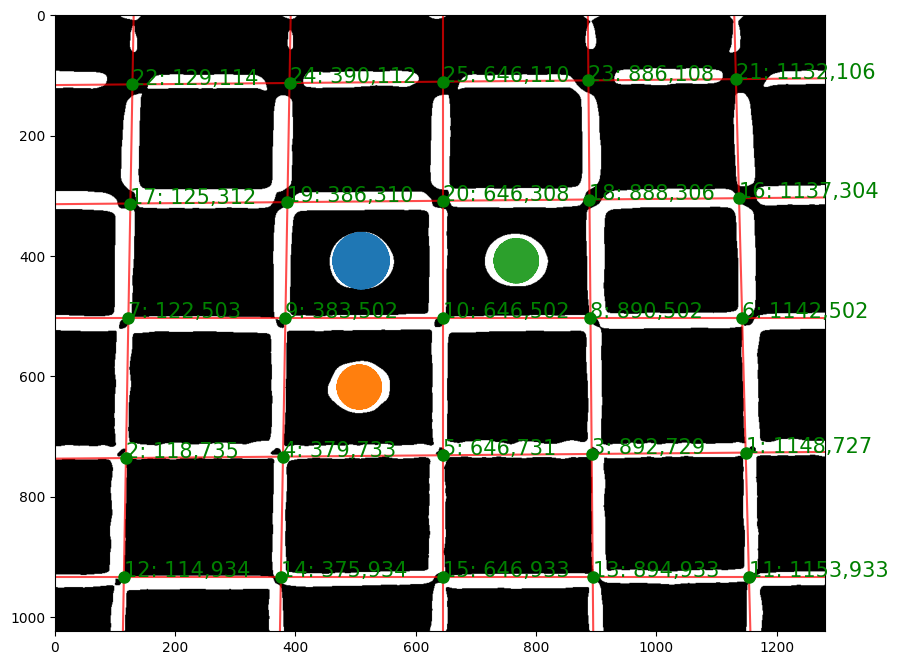

In [38]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
shape = thresholded.shape
rad_min = int(min(shape) / (4*(min(GRID_DIMENSIONS) + 3)))
rad_max = int(max(shape) / (4*(max(GRID_DIMENSIONS) + 1)))

hough_radii = np.arange(rad_min, rad_max, 10)
hough_res = hough_circle(thresholded, hough_radii)

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3, min_xdistance = 100, min_ydistance = 100)

peaks = hough_line_peaks(h, theta, d, num_peaks=NUM_LINES, min_distance=100)
intersections = hough_intersections(peaks, thresholded.shape)
print(f"Found {len(intersections)} intersections")
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(thresholded, cmap='gray')

for _, angle, dist in zip(*peaks):
    x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='red', alpha=0.7)

k = 0

for inter in intersections:
    x, y = inter['point']
    k = k+1
    ax.plot(x, y, 'go', markersize=8)
    ax.text(x,y,str(k) + ': ' + str(int(x)) +','+ str(int(y)),c = 'g',fontsize = 15)

for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=thresholded.shape)
    ax.plot(circx, circy)

    print(center_x,center_y)


ax.set_xlim(0, thresholded.shape[1])
ax.set_ylim(thresholded.shape[0], 0)
plt.show()



In [ ]:
points = np.array
k = 0
for inter in intersections:
    k = k+1
    x,y = inter['point']
    print('[',x,',',y,'],')

[ 1148.42433263073 , 727.0059164517294 ],
[ 118.17308334135102 , 735.9967828955419 ],
[ 892.3977204971571 , 729.2402268467349 ],
[ 379.252610694517 , 733.718376377457 ],
[ 646.0 , 731.390507177458 ],
[ 1142.5585312714911 , 502.9999999999999 ],
[ 122.24005731485848 , 503.0 ],
[ 890.4233519485144 , 502.9999999999999 ],
[ 383.2798149343184 , 502.99999999999994 ],
[ 646.0 , 502.99999999999994 ],
[ 1153.844663467811 , 933.9999999999999 ],
[ 114.71692433079672 , 934.0 ],
[ 894.1846319663314 , 933.9999999999999 ],
[ 375.7566819502566 , 934.0 ],
[ 646.0000000000001 , 933.9999999999999 ],
[ 1137.3497967910505 , 304.08645530467953 ],
[ 125.55798188461074 , 312.91622870513993 ],
[ 888.706395981345 , 306.2563333905905 ],
[ 386.6375092377767 , 310.63782218705506 ],
[ 646.0 , 308.37440002029126 ],
[ 1132.165971504392 , 106.12415434223065 ],
[ 129.01474290485996 , 114.87852248835604 ],
[ 886.9785419526672 , 108.26387262388455 ],
[ 390.094270258026 , 112.60011597027116 ],
[ 646.0 , 110.3668604999153 ]

In [58]:
# NERDS TEST

L = 2.3 # mm


oy_left, ox_left = 646,502
oy_right, ox_right = 631,523

pixel_density_left = (L*4)/1020.0004902
pixel_density_right = (L*4)/1155.04328923

grid_locations_right = np.array([[2,1],[-2,1],[1,1],[-1,1],[0,1],[2,2],[-2,2],[1,2],[-1,2],[0,2],[2,-1],[-2,-1],[1,-1],[-1,-1],[0,-1]])
grid_locations_left = np.array([[2,-1],[-2,-1],[1,-1],[-1,-1],[0,-1],[2,-2],[-2,-2],[1,-2],[-1,-2],[0,-2],[2,1],[-2,1],[1,1],[-1,1],[0,1],[2,2],[-2,2],[1,2],[-1,2],[0,2]])

pixel_positions_left = [
[ 1148.42433263073 , 727.0059164517294 ],
[ 118.17308334135102 , 735.9967828955419 ],
[ 892.3977204971571 , 729.2402268467349 ],
[ 379.252610694517 , 733.718376377457 ],
[ 646.0 , 731.390507177458 ],

[ 1153.844663467811 , 933.9999999999999 ],
[ 114.71692433079672 , 934.0 ],
[ 894.1846319663314 , 933.9999999999999 ],
[ 375.7566819502566 , 934.0 ],
[ 646.0000000000001 , 933.9999999999999 ],
[ 1137.3497967910505 , 304.08645530467953 ],
[ 125.55798188461074 , 312.91622870513993 ],
[ 888.706395981345 , 306.2563333905905 ],
[ 386.6375092377767 , 310.63782218705506 ],
[ 646.0 , 308.37440002029126 ],
[ 1132.165971504392 , 106.12415434223065 ],
[ 129.01474290485996 , 114.87852248835604 ],
[ 886.9785419526672 , 108.26387262388455 ],
[ 390.094270258026 , 112.60011597027116 ],
[ 646.0 , 110.3668604999153 ]]

pixel_positions_right = [
    [1205.7034293549664, 304.5332094682522],
[60.75766464123691, 294.54141915200603],
[926.021232305944, 302.0924599111764],
[339.4213762514247, 296.97328052131036],
[635.8687971269561, 299.5603379702026],
[1203.7571155058029, 81.50773276459189],
[68.54292021853988, 71.60086856812707],
[933.806487883247, 79.15190932729743],
[341.36739366756206, 73.98177167800013],
[639.7608319592309, 76.58581176360153],

[1209.8151914134078, 775.6944733979985],
[45.37541763542259, 735.0313404708747],
[909.8484830069405, 765.219405118538],
[335.51008324619994, 745.163066250234],
[627.9125403219653, 755.3739850525974]
]


grid_locations_left = grid_locations_left * L
grid_locations_right = grid_locations_right * L

In [39]:
oy_left, ox_left = 621, 520
oy_right, ox_right = 613, 514

pixel_density_left = 1.5/184 # mm/px
pixel_density_right = 4.6/705

L = 2.3 # mm

# Y,X

grid_locations_left = np.array([[-2,-1],[-1,-1],[0,-1],[1,-1],[2,-1], 
                          [-2,1],[-1,1],[0,1],[1,1],[2,1]])
grid_locations_right = np.array([[-1,-1],[0,-1],[1,-1],[-1,1],[0,1],[1,1]])

grid_locations_left = grid_locations_left * L
grid_locations_right = grid_locations_right * L

pixel_positions_left = [
    [56.09376258814864, 740.0],
    [335.13626211239887, 740.0],
    [617.1792186207808, 739.9999999999999],
    [889.0501874133441, 739.9999999999999],
    [1161.533202203056, 739.9999999999999],

    [63.29467288357632, 327.4601254684074],
    [342.37968488178825, 325.0245874663167],
    [624.4656109875077, 322.5628608835583],
    [881.7246072869334, 320.3177956348699],
    [1146.7967962164291, 318.00454568707517]]

pixel_positions_right = [
    [252.93247220010684, 780.0],
    [618.48132067974, 779.9999999999999],
    [964.7598146137658, 779.9999999999999],

    [271.63674338364126, 244.37975291596973],
    [627.776356818787, 247.48773623747027],
    [955.5147022157868, 250.347865447712]]



In [59]:
cam_coords = lambda px_pos, o1, o2, mm_per_px:[
    (px_pos[0] - o1) * mm_per_px,
    -1 * (px_pos[1] - o2) * mm_per_px
    ]

apply = lambda target_list, function, arguments: \
    [function(*((element,) + arguments)) for element in target_list] # function arguments must have format (thing to apply, arguments)

# camera_positions_left = [[(position[0] - oy_left) * pixel_density_left,
#                         -1*(position[1]-ox_left)*pixel_density_left]
#                         for position in pixel_positions_left]
# camera_positions_right = [[(position[0] - oy_right)*pixel_density_right, 
#                         -1*(position[1]-ox_right)*pixel_density_right]
#                         for position in pixel_positions_right]


# camera_positions_left = [cam_coords(px_pos,oy_left,ox_left, pixel_density_left) for px_pos in pixel_positions_left]
# camera_positions_right = [cam_coords(px_pos,oy_right,ox_right, pixel_density_right) for px_pos in pixel_positions_right]


left_parameters = (oy_left, ox_left, pixel_density_left)
right_parameters = (oy_right, ox_right, pixel_density_right)

camera_positions_left = apply(pixel_positions_left, cam_coords, left_parameters)
camera_positions_right = apply(pixel_positions_right, cam_coords, right_parameters)

In [60]:
camera_positions_left

[[4.531668273312675, -2.0294641534437083],
 [-4.7607895093338755, -2.110558203964072],
 [2.222409744263323, -2.0496167473214038],
 [-2.405955688442123, -2.090007880539943],
 [0.0, -2.069011423336484],
 [4.580557508347618, -3.896468715638269],
 [-4.791962693271135, -3.8964687156382705],
 [2.238526977219926, -3.896468715638269],
 [-2.4374875796090465, -3.8964687156382705],
 [1.0254102003752816e-15, -3.896468715638269],
 [4.431780350998958, 1.7851017020981312],
 [-4.694180652523751, 1.7054606469567681],
 [2.1891154607097802, 1.765530262101601],
 [-2.3393468316319974, 1.726010970380898],
 [0.0, 1.7464261408972805],
 [4.385024302256366, 3.5706431663943117],
 [-4.663002038697734, 3.4916822367495017],
 [2.173530902450677, 3.551343755874072],
 [-2.308168217805981, 3.5122325601736315],
 [0.0, 3.5323756390492558]]

In [61]:
# ASSUMING THE ROTATION OF THE IMAGE IS ZERO, AND THERE IS NO FISHEYE DISTORTION

#  = lambda grid_loc, cam_loc: (cam_loc[1]/abs(cam_loc[1]))*(((grid_loc[0] ** 2) + (grid_loc[1]**2) - (cam_loc[0]**2) - (cam_loc[1]**2)))


# BETTER
phi_approx = lambda grid_loc, cam_loc: np.arcsin(abs(cam_loc[1])/(((grid_loc[0] ** 2) + (grid_loc[1]**2) - (cam_loc[0]**2)))**(1/2))
# SIMPLIFIED
# phi_approx = lambda grid_loc, cam_loc: np.arcsin(cam_loc[1]/grid_loc[1])

phis_left = [phi_approx(grid_locations_left[i], camera_positions_left[i]) for i in range(len(grid_locations_left))]
phis_right = [phi_approx(grid_locations_right[i], camera_positions_right[i]) for i in range(len(grid_locations_right))]

/var/folders/72/cs7rlb5x6_q013gsm8wrq_b00000gn/T/ipykernel_951/4249666224.py:7: RuntimeWarning:

invalid value encountered in arcsin



In [9]:
abs(-2.110558203964072)/(((4.6 ** 2) + (2.3**2) - (4.7607895093338755**2)))**(1/2)

1.0848534881864438

In [62]:
# FIX FIX FIX

phis_left, phis_right
del phis_left[1]

In [63]:
phi_left_approx = sum(phis_left) / len(phis_left)
phi_right_approx = sum(phis_right) / len(phis_right)

In [64]:
print(f'Left Camera Angle (approximate): {phi_left_approx} radians')
print(f'Right Camera Angle (approximate): {phi_right_approx} radians')

Left Camera Angle (approximate): 0.9546257629474507 radians
Right Camera Angle (approximate): 0.903177020949084 radians


In [51]:
# [X,Y,Z]

# world_pos = lambda pos_cam_left, pos_cam_right, phi_left, phi_right:[
#     ((pos_cam_left[1]/math.sin(phi_left)) - (pos_cam_right[1]/math.cos(phi_right)*math.tan(phi_left)))/(1+(math.tan(phi_right)/math.tan(phi_left))),
#     ((-1*pos_cam_left[0]) + pos_cam_right[0]) / 2,
#     (pos_cam_right[1]/math.cos(phi_right)) + (pos_cam_left[1] *math.tan(phi_right)/math.tan(phi_left)) / (1+(math.tan(phi_right)/math.tan(phi_left)))
# ]
# world_pos = lambda pos_cam_left, pos_cam_right, phi_left, phi_right: [
#     (pos_cam_left[1]/(math.sin(phi_left)+(math.tan(phi_right)*math.cos(phi_left)))+pos_cam_right[1]/(math.sin(phi_right)+(math.tan(phi_left)*math.cos(phi_right)))),
#     ((-1*pos_cam_left[0]) + pos_cam_right[0]) / 2,
#     ((pos_cam_left[1]/math.sin(phi_left))+(pos_cam_right[1]/math.sin(phi_right)))/((1/math.tan(phi_left))+(1/math.tan(phi_right)))
# ]
# fixed, antisymmetric version
world_pos = lambda pos_cam_left, pos_cam_right, phi_left, phi_right: [
    ((pos_cam_left[1]*math.tan(phi_right)*math.cos(phi_left)) - (pos_cam_right[1]/math.sin(phi_right))) / (1+(math.tan(phi_left)/math.tan(phi_right))),
    ((-1*pos_cam_left[0]) + pos_cam_right[0]) / 2,
    ((pos_cam_left[1]/math.sin(phi_left))+(pos_cam_right[1]/math.sin(phi_right)))/((1/math.tan(phi_left))+(1/math.tan(phi_right)))
]

In [52]:
# GETTING HEIGHTS

px_coords_left = [672,568]
px_coords_right = [536,320]

print(cam_coords(px_coords_left, oy_left, ox_left, pixel_density_left),
      cam_coords(px_coords_right, oy_right, ox_right, pixel_density_right))

[0.4157608695652174, -0.3913043478260869] [-0.5024113475177304, 1.2658156028368792]


In [53]:
world_pos(cam_coords(px_coords_left, oy_left, ox_left, pixel_density_left),
             cam_coords(px_coords_right, oy_right, ox_right, pixel_density_right),
             phi_left_approx,
             phi_right_approx
            )

[-1.0630474739121873, -0.4590861085414739, 0.6035609342914603]

In [54]:
armored_left_px = [
[562,369],
[593,372],
[597,349],
[576,333],
[552,350],
[570,390],
[601,442],
[633,450],
[638,420],
[613,397],
[688,414]
]
armored_left_px = [
 [786, 432],
 [755, 405],
 [726, 381],
 [693, 358],
 [656, 336],
 [619, 342],
 [574, 357],
 [540, 377],
 [504, 400],
 [479, 378],
 [508, 352],
 [548, 339],
 [587, 320],
 [633, 307],
 [688, 316],
 [725, 339],
 [758, 360],
 [789, 387],
 [815, 419],
 [815, 376],
 [786, 345],
 [754, 321],
 [720, 297],
 [674, 282],
 [638, 270],
 [596, 285],
 [553, 301],
 [514, 315],
 [489, 337],
 [466, 348],
 [442, 375],
 [496, 302],
 [531, 278],
 [570, 262],
 [610, 249],
 [669, 252],
 [709, 263],
 [749, 284],
 [784, 305],
 [811, 338]]

armored_right_px = [

[678,284],
[637,274],
[633,309],
[654,341],
[690,320],
[665,252],
[629,204],
[590,205],
[577,230],
[610,250],
[644,226]
]

armored_right_px = [
[476, 352],
 [498, 344],
 [522, 338],
 [547, 337],
 [575, 332],
 [610, 336],
 [641, 335],
 [672, 341],
 [699, 347],
 [719, 376],
 [694, 362],
 [665, 356],
 [632, 353],
 [595, 349],
 [552, 350],
 [522, 354],
 [498, 358],
 [473, 365],
 [456, 373],
 [452, 394],
 [474, 381],
 [500, 376],
 [530, 369],
 [563, 369],
 [596, 369],
 [627, 370],
 [661, 371],
 [691, 381],
 [715, 392],
 [737, 402],
 [755, 416],
 [707, 406],
 [679, 398],
 [649, 394],
 [614, 398],
 [575, 392],
 [540, 391],
 [505, 392],
 [480, 399],
 [455, 409]]
camera_positions_left = apply(armored_left_px, cam_coords, left_parameters)
camera_positions_right = apply(armored_right_px, cam_coords, right_parameters)

In [55]:
world_coordinates_armored = [world_pos(camera_positions_left[i],camera_positions_right[i], phi_left_approx,phi_right_approx) for i in range(len(camera_positions_left))]

In [71]:
# Alternative with Plotly (more interactive features) THIS SECTION VIBECODED !!!!!
def plot_3d_spheres(points, radius=0.2):
    """
    Plot 3D points as actual spheres with radius in axis units
    Parameters:
    points (list or numpy.ndarray): N x 3 array/list of 3D coordinates
    radius (float): Radius of spheres in axis units
    """
    try:
        import plotly.graph_objects as go
        if isinstance(points, list):
            points = np.array(points)
        x, y, z = points[:, 0], points[:, 1], points[:, 2]
        # Create sphere surfaces for each point
        fig = go.Figure()
        # Add each point as a small sphere
        for i in range(len(points)):
            # Create sphere coordinates
            u = np.linspace(0, 2 * np.pi, 10)
            v = np.linspace(0, np.pi, 10)
            sphere_x = radius * np.outer(np.cos(u), np.sin(v)) + x[i]
            sphere_y = radius * np.outer(np.sin(u), np.sin(v)) + y[i]
            sphere_z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + z[i]
            fig.add_trace(go.Surface(
                x=sphere_x, y=sphere_y, z=sphere_z,
                showscale=False,
                opacity=0.7,
                colorscale='Blues',
                surfacecolor=np.ones_like(sphere_x) * i
            ))
        fig.update_layout(
            title=f'3D Points as Spheres (radius={radius} units)',
            scene=dict(
                xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
                xaxis=dict(range=[-2, 2]),
                yaxis=dict(range=[-2, 2]),
                zaxis=dict(range=[0, 4]),
                aspectmode='cube'
            ),
            width=800, height=600
        )
        try:
            fig.show()
        except:
            fig.show(renderer="browser")
    except ImportError:
        print("Plotly not installed")

def plot_3d_points_plotly(points):
    """
    Create an interactive 3D scatter plot using Plotly
    Parameters:
    points (list or numpy.ndarray): N x 3 array/list of 3D coordinates
    """
    try:
        import plotly.graph_objects as go
        import numpy as np
        # Convert to numpy array if it's a list
        if isinstance(points, list):
            points = np.array(points)
        # Extract coordinates
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]
        # Create 3D scatter plot with z-value coloring
        fig = go.Figure(data=[go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=40,
                color=z, # Color based on z-values
                colorscale='Viridis', # Color scheme
                opacity=0.6,
                sizemode='diameter',
                colorbar=dict(
                    title=dict(text="Z Value", font=dict(size=16)),
                    tickfont=dict(size=14)
                )
            )
        )])
        # Update layout with larger axis labels
        fig.update_layout(
            title='Interactive 3D Point Cloud',
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
                xaxis=dict(
                    range=[-2, 2],
                    title=dict(font=dict(size=30)), # Larger axis label
                    tickfont=dict(size=20) # Larger tick labels
                ),
                yaxis=dict(
                    range=[-2, 2],
                    title=dict(font=dict(size=30)), # Larger axis label
                    tickfont=dict(size=20) # Larger tick labels
                ),
                zaxis=dict(
                    range=[-2, 2],
                    title=dict(font=dict(size=30)), # Larger axis label
                    tickfont=dict(size=20) # Larger tick labels
                ),  # <-- Added missing comma here
                aspectmode="cube"
            ),
            width=1600,
            height=1600
        )
        # Try different display methods depending on environment
        try:
            fig.show()
        except ValueError:
            # If running in Jupyter with issues, try browser display
            fig.show(renderer="browser")
        except Exception as e:
            print(f"Plotly display error: {e}")
            print("Trying to open in browser...")
            fig.show(renderer="browser")
    except Exception as e:
        print(f"Error creating plot: {e}")

In [57]:
plot_3d_points_plotly(world_coordinates_armored)

In [203]:
world_coordinates_armored

[[-0.2531306547732081, 0.45254586802343505, 2.927823021162838],
 [-0.31572172808500537, 0.19242830712303421, 3.0136646235547664],
 [-0.029240242437003596, 0.16307431390687632, 2.767393229168727],
 [0.2055665094377836, 0.31718277829170516, 2.520437299075239],
 [0.01641995941046452, 0.5324556737588653, 2.6543315369265215],
 [-1.0181171391698955, 0.13372032069071846, 3.4021929214742848],
 [-1.0566200839323723, -0.12394850447116866, 3.3576370831485813],
 [-0.7787994883507982, -0.18674028677150784, 3.240546662343037],
 [-0.561936030210076, 0.022821461609620723, 3.142540388579745],
 [-0.7650061857388512, -0.1719630743139069, 3.3060876505555767]]

In [65]:
import pandas as pd
from io import StringIO
tsv =  StringIO("""
id\ttype\tarea\tmean\tmin\tmax\tx\ty\txm\tym
1	nerds_bearing_test_left.tif	0.075	124.910	67	186	5.896	6.693	5.901	6.688
2	nerds_bearing_test_right.tif	0.099	164.242	74	255	7.375	3.812	7.374	3.796
3	nerds_bearing_test_left.tif	0.081	125.005	58	255	6.068	7.099	6.074	7.085
4	nerds_bearing_test_right.tif	0.106	185.375	82	255	7.182	3.203	7.173	3.188
5	nerds_bearing_test_left.tif	0.078	142.605	66	255	6.260	6.844	6.266	6.846
6	nerds_bearing_test_right.tif	0.106	193.812	89	255	6.964	3.255	6.964	3.238
7	nerds_bearing_test_left.tif	0.081	145.043	63	255	6.349	7.109	6.355	7.096
8	nerds_bearing_test_right.tif	0.106	208.200	106	255	6.870	3.036	6.876	3.038
9	nerds_bearing_test_left.tif	0.081	189.001	93	255	6.818	7.120	6.807	7.106
10	nerds_bearing_test_right.tif	0.106	228.467	131	255	6.359	2.984	6.357	2.978
11	nerds_bearing_test_left.tif	0.081	131.899	73	195	6.859	7.609	6.863	7.598
12	nerds_bearing_test_right.tif	0.106	230.641	104	255	6.318	2.880	6.321	2.885
13	nerds_bearing_test_left.tif	0.081	139.553	59	197	6.870	6.693	6.874	6.691
14	nerds_bearing_test_right.tif	0.106	207.051	116	255	6.297	3.286	6.295	3.276
15	nerds_bearing_test_left.tif	0.081	138.870	67	197	6.974	6.297	6.970	6.308
16	nerds_bearing_test_right.tif	0.106	157.240	47	255	6.193	4.099	6.192	4.068
17	nerds_bearing_test_left.tif	0.081	144.740	79	197	6.953	6.391	6.954	6.386
18	nerds_bearing_test_right.tif	0.106	224.310	132	255	6.193	3.766	6.201	3.759
19	nerds_bearing_test_left.tif	0.081	139.553	59	197	6.870	6.693	6.874	6.691
20	nerds_bearing_test_right.tif	0.106	208.448	133	255	6.286	3.276	6.288	3.267
21	nerds_bearing_test_right.tif	0.106	207.286	115	255	5.943	3.474	5.944	3.460
22	nerds_bearing_test_left.tif	0.081	158.578	101	201	7.349	6.516	7.347	6.518
23	nerds_bearing_test_right.tif	0.106	190.493	81	255	5.745	3.901	5.750	3.879
24	nerds_bearing_test_left.tif	0.081	152.782	97	195	7.214	6.953	7.214	6.944
25	nerds_bearing_test_right.tif	0.106	241.778	166	255	5.911	3.182	5.914	3.181
26	nerds_bearing_test_left.tif	0.081	132.073	74	199	7.130	7.339	7.130	7.333
27	nerds_bearing_test_right.tif	0.106	231.898	104	255	6.005	3.016	6.005	3.019
28	nerds_bearing_test_left.tif	0.081	156.522	106	212	7.505	6.786	7.502	6.781
29	nerds_bearing_test_right.tif	0.106	222.338	102	255	5.589	3.651	5.595	3.641
30	nerds_bearing_test_left.tif	0.081	140.045	83	199	7.464	7.151	7.467	7.141
31	nerds_bearing_test_right.tif	0.106	209.815	115	255	5.641	3.276	5.642	3.266
32	nerds_bearing_test_left.tif	0.081	135.559	73	194	7.661	7.078	7.652	7.075
33	nerds_bearing_test_right.tif	0.106	209.521	100	255	5.453	3.599	5.463	3.587
""")
df = pd.read_csv(tsv, sep='\t')
left_positions = df.loc[df['type'] == 'nerds_bearing_test_left.tif']
left_positions = left_positions[['x','y']]
right_positions = df.loc[df['type'] == 'nerds_bearing_test_right.tif']
right_positions = right_positions[['x','y']]

left_positions = left_positions * 96
right_positions = right_positions * 96

In [66]:
print(left_positions.to_numpy())

[[566.016 642.528]
 [582.528 681.504]
 [600.96  657.024]
 [609.504 682.464]
 [654.528 683.52 ]
 [658.464 730.464]
 [659.52  642.528]
 [669.504 604.512]
 [667.488 613.536]
 [659.52  642.528]
 [705.504 625.536]
 [692.544 667.488]
 [684.48  704.544]
 [720.48  651.456]
 [716.544 686.496]
 [735.456 679.488]]


In [67]:
left_positions.to_numpy()

array([[566.016, 642.528],
       [582.528, 681.504],
       [600.96 , 657.024],
       [609.504, 682.464],
       [654.528, 683.52 ],
       [658.464, 730.464],
       [659.52 , 642.528],
       [669.504, 604.512],
       [667.488, 613.536],
       [659.52 , 642.528],
       [705.504, 625.536],
       [692.544, 667.488],
       [684.48 , 704.544],
       [720.48 , 651.456],
       [716.544, 686.496],
       [735.456, 679.488]])

In [68]:
camera_positions_left = apply(left_positions.to_numpy(), cam_coords, left_parameters)
camera_positions_right = apply(right_positions.to_numpy(), cam_coords, right_parameters)

world_coordinates_nerds = [world_pos(camera_positions_left[i],camera_positions_right[i], phi_left_approx,phi_right_approx) for i in range(len(camera_positions_left))]

In [73]:
plot_3d_points_plotly(world_coordinates_nerds)
world_coordinates_nerds

[[-1.193396638021642, 0.6673671567847173, 0.02657146914795829],
 [-1.5959310149093429, 0.5191129069665101, 0.13496739512825107],
 [-1.4953844999326114, 0.35264175445733303, 0.281922831023648],
 [-1.6758791605875365, 0.27817161497530496, 0.23653457194154212],
 [-1.7031417739855939, -0.12024492232606776, 0.26256913821594546],
 [-1.8979275829015483, -0.15367075868017355, -0.016453249781544665],
 [-1.4357494280142375, -0.16646189932384456, 0.3688082697845068],
 [-0.9422261529126141, -0.2512493866610901, 0.12059196731682113],
 [-1.1238871430807125, -0.24215762632460092, 0.2706114996520856],
 [-1.4403568955045911, -0.17066745598591432, 0.3753146728384339],
 [-1.2959681761651596, -0.509183083041539, 0.37197654148566117],
 [-1.2304795806790338, -0.5264360722242181, -0.2156691269014498],
 [-1.6776892227820444, -0.42660335761430157, -0.0215232589533885],
 [-1.5880830291341788, -0.5530178274718465, 0.47854643829876276],
 [-1.4051343520058126, -0.6943137542600858, -0.19338618346156003],
 [-1.55598